# Améliorer les deux modèles ayant la meilleure performance.


L'execution de ce notebook prends environ 30 min.


In [50]:
import numpy as np
import pandas as pd
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import pickle

ordinal_encoder = OrdinalEncoder()

db = pd.read_csv("data.csv")

repeat_columns = []
repeat_columns += ["identifierHash", "type", "country", "gender", "civilityTitle"]
db1 = db.drop(repeat_columns, axis=1)
db1.head()

string_columns = [
    "language",
    "countryCode",
    "hasAnyApp",
    "hasAndroidApp",
    "hasIosApp",
    "hasProfilePicture",
]

for var in string_columns:
    var_cat = db[[var]]
    var_cat_encoded = ordinal_encoder.fit_transform(var_cat)
    var_cat_df = pd.DataFrame(var_cat_encoded)
    var_cat_df.columns = [var + "_encoded"]
    db1 = db1.merge(var_cat_df, how="inner", left_index=True, right_index=True)

db2 = db1.drop(string_columns, axis=1)
db2.head()
db2.info()
no_columns = ["seniority", "seniorityAsMonths", "seniorityAsYears"]
db3 = db2.drop(no_columns, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   socialNbFollowers          98913 non-null  int64  
 1   socialNbFollows            98913 non-null  int64  
 2   socialProductsLiked        98913 non-null  int64  
 3   productsListed             98913 non-null  int64  
 4   productsSold               98913 non-null  int64  
 5   productsPassRate           98913 non-null  float64
 6   productsWished             98913 non-null  int64  
 7   productsBought             98913 non-null  int64  
 8   civilityGenderId           98913 non-null  int64  
 9   daysSinceLastLogin         98913 non-null  int64  
 10  seniority                  98913 non-null  int64  
 11  seniorityAsMonths          98913 non-null  float64
 12  seniorityAsYears           98913 non-null  float64
 13  language_encoded           98913 non-null  flo

In [51]:
X = db3[
    [
        "socialNbFollowers",
        "socialNbFollows",
        "socialProductsLiked",
        "productsListed",
        "productsSold",
        "productsPassRate",
        "productsWished",
        "civilityGenderId",
        "daysSinceLastLogin",
        "language_encoded",
        "countryCode_encoded",
        "hasAnyApp_encoded",
        "hasAndroidApp_encoded",
        "hasIosApp_encoded",
        "hasProfilePicture_encoded",
    ]
]
Y = db3["HasBought"] = db3["productsBought"].apply(
    lambda x: "2" if x >= 3 else ("1" if x < 3 and x > 0 else "0")
)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42
)

# Logistic Regression


Model Built


In [52]:
# define logistic regression function
import numpy as np
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class="multinomial", solver="newton-cg")

Model Evaluation


Original Model Evaluation: 
Accuracy on train set: 0.947
Accuracy on test set: 0.945
Model Evaluation:
classification report of train set: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     62691
           1       0.30      0.02      0.04      2754
           2       0.65      0.17      0.27       826

    accuracy                           0.95     66271
   macro avg       0.63      0.40      0.43     66271
weighted avg       0.92      0.95      0.93     66271

classification report of test set: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     30803
           1       0.21      0.02      0.03      1388
           2       0.64      0.18      0.28       451

    accuracy                           0.94     32642
   macro avg       0.60      0.40      0.43     32642
weighted avg       0.91      0.94      0.92     32642

Confusion matrix of test set: 
Original Model's features selec

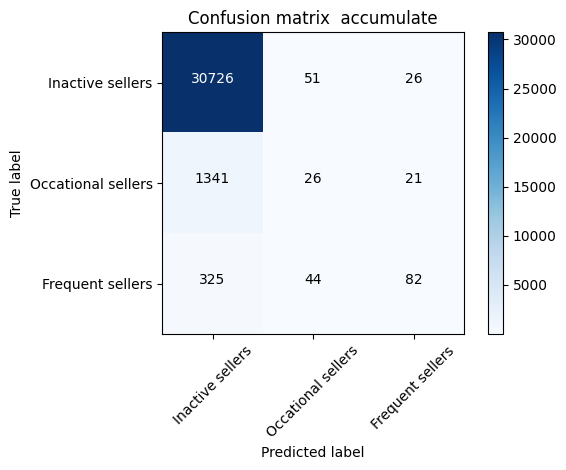

In [53]:
org(X, Y, model)

Le score F1 du jeu d'entraînement et du jeu de test est extrêmement faible.


In [54]:
# according to the correlation heatmap, pairplot and feature selection, keep top 7

d_columns = [
    "productsSold",
    "hasAnyApp_encoded",
    "productsPassRate",
    "hasProfilePicture_encoded",
    "productsListed",
    "socialNbFollows",
    "socialProductsLiked",
    "socialNbFollowers",
]

# socialNBFollows & socialProductsLiked has no relationship with a user's willingness to buy a product
Xf = X.drop(d_columns, axis=1)
Yf = db3["HasBought"]
Xy = db3[["productsBought"]]
Xf_pp = pd.concat([Xf, Xy], join="outer", axis=1)

Visualiser la relation entre une variable individuelle et la variable dépendante.


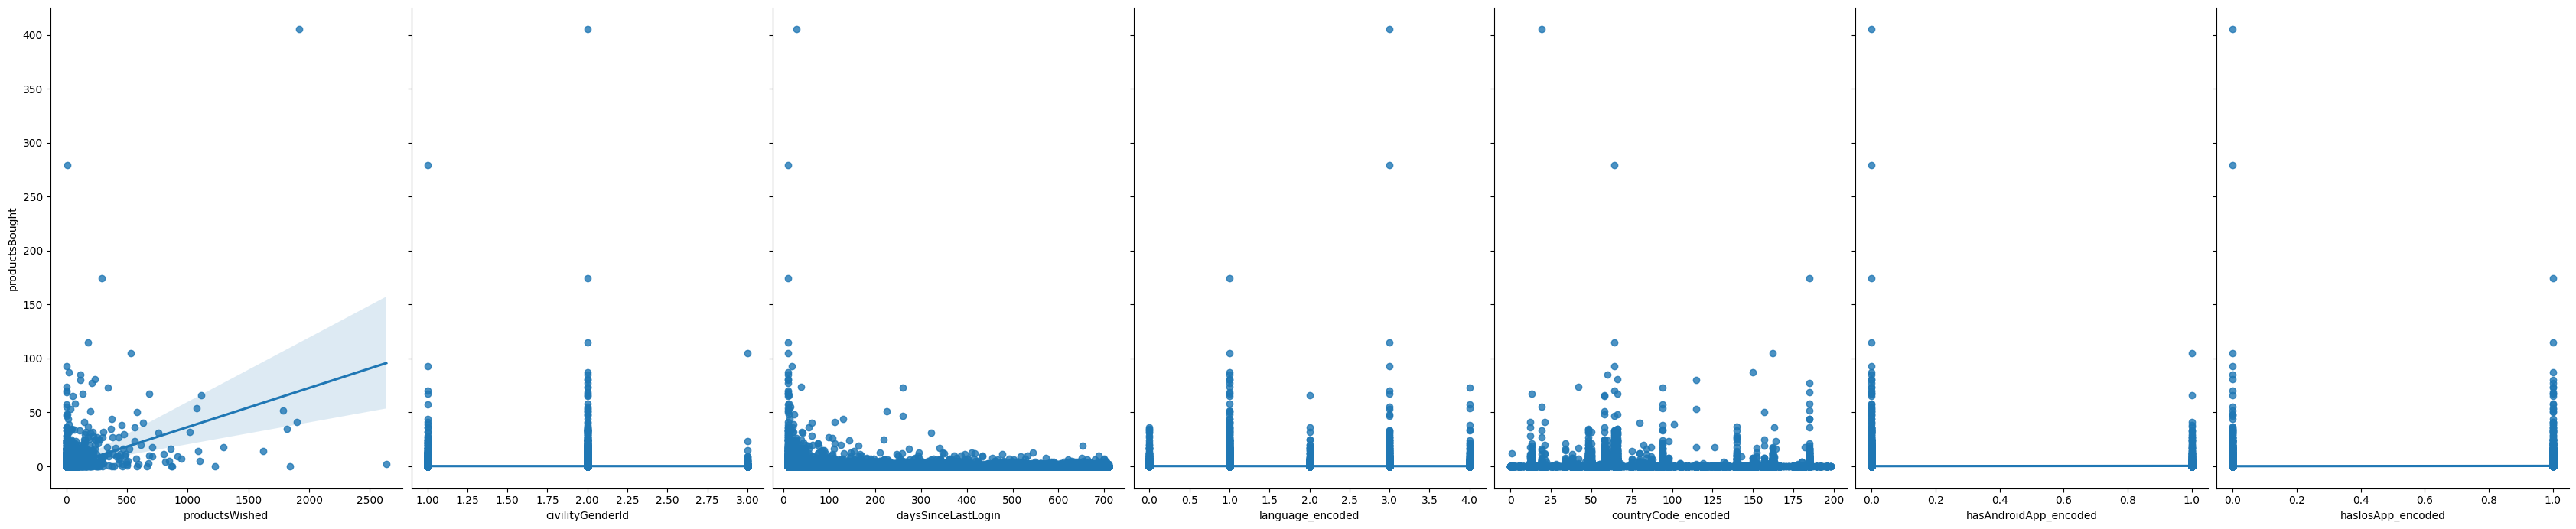

In [55]:
import seaborn as sns

sns.pairplot(
    Xf_pp, x_vars=Xf.columns, y_vars="productsBought", height=7, aspect=0.7, kind="reg"
)

Il n'y a pas de forte relation linéaire, seulement une faible relation linéaire entre les variables productsWished et productsBought.


Model Re-evaluation with the Filtered Dataset


Filtered Model Evaluation: 
Accuracy on train set: 0.947
Accuracy on test set: 0.945
Model Evaluation:
classification report of train set: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     62691
           1       0.31      0.01      0.02      2754
           2       0.74      0.13      0.22       826

    accuracy                           0.95     66271
   macro avg       0.67      0.38      0.40     66271
weighted avg       0.92      0.95      0.92     66271

classification report of test set: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     30803
           1       0.20      0.01      0.01      1388
           2       0.68      0.13      0.22       451

    accuracy                           0.94     32642
   macro avg       0.61      0.38      0.40     32642
weighted avg       0.91      0.94      0.92     32642

Confusion matrix of test set: 
Filtered Model's Feature Import

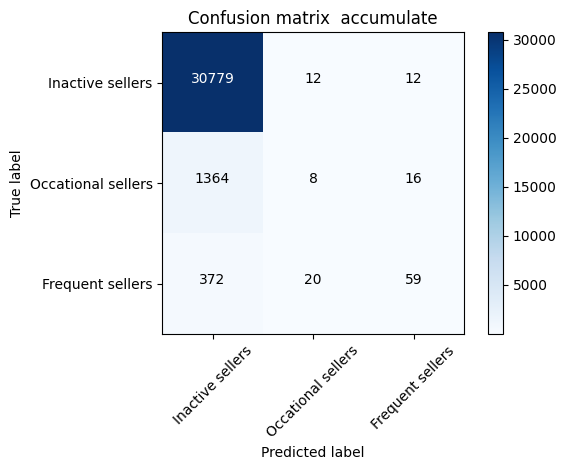

In [56]:
filt(Xf, Yf, model)

En régression logistique, si l'interception est inférieure à 1, cela implique une réduction de la probabilité que l'événement se produise. En résumé :
b) valeur négative du logit = logistic < 1 = diminution de la probabilité de l'événement lorsque vous avez un changement positif dans les variables indépendantes.


New users' prediction


In [57]:
c = Xf
c.dataframeName = "Formean"
c.describe()

,productsWished,civilityGenderId,daysSinceLastLogin,language_encoded,countryCode_encoded,hasAndroidApp_encoded,hasIosApp_encoded
count,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000
mean,1.562595,1.773993,581.291236,1.757201,93.711635,0.048720,0.217636
std,25.192793,0.428679,208.855888,1.154693,55.173154,0.215282,0.412640
min,0.000000,1.000000,11.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,572.000000,1.000000,64.000000,0.000000,0.000000
50%,0.000000,2.000000,694.000000,1.000000,66.000000,0.000000,0.000000
75%,0.000000,2.000000,702.000000,3.000000,152.000000,0.000000,0.000000
max,2635.000000,3.000000,709.000000,4.000000,198.000000,1.000000,1.000000


In [58]:
# try to predict when a user using mean
newdata = [[2, 2, 581, 2, 94, 0, 0]]
Y_pred1 = model.predict(newdata)
print("prediction with mean features: ", Y_pred1)
# socialNbFollowers affect the prediction the most

# try to predict when a user using max
newdata1 = [[2635, 3, 709, 4, 198, 1, 1]]
Y_pred2 = model.predict(newdata1)
print("prediction with max features: ", Y_pred2)

prediction with mean features:  ['0']
prediction with max features:  ['2']


In [59]:
print(db3["HasBought"].value_counts())
# very imbalanced sample

HasBought
0    93494
1     4142
2     1277
Name: count, dtype: int64


## Bootstrap to resample the imbalanced data


Re-diviser l'ensemble de données équilibré.


In [60]:
from collections import Counter
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
X_ros, Y_ros = ros.fit_resample(X, Y)
print("Original dataset shape", Counter(Y))
print("Resample dataset shape", Counter(Y_ros))

X_ros = pd.DataFrame(
    X_ros,
    columns=[
        "socialNbFollowers",
        "socialNbFollows",
        "socialProductsLiked",
        "productsListed",
        "productsSold",
        "productsPassRate",
        "productsWished",
        "civilityGenderId",
        "daysSinceLastLogin",
        "language_encoded",
        "countryCode_encoded",
        "hasAnyApp_encoded",
        "hasAndroidApp_encoded",
        "hasIosApp_encoded",
        "hasProfilePicture_encoded",
    ],
)
Y_ros.to_frame()

Original dataset shape Counter({'0': 93494, '1': 4142, '2': 1277})
Resample dataset shape Counter({'0': 93494, '1': 93494, '2': 93494})


,productsBought
0,0
1,0
2,0
3,0
4,0
...,...
280477,2
280478,2
280479,2
280480,2


Balanced Model Evaluation


Balanced Model Evaluation: 
Accuracy on train set: 0.647
Accuracy on test set: 0.645
Model Evaluation:
classification report of train set: 
              precision    recall  f1-score   support

           0       0.69      0.84      0.76     62836
           1       0.52      0.34      0.41     62724
           2       0.68      0.76      0.72     62362

    accuracy                           0.65    187922
   macro avg       0.63      0.65      0.63    187922
weighted avg       0.63      0.65      0.63    187922

classification report of test set: 
              precision    recall  f1-score   support

           0       0.68      0.84      0.75     30658
           1       0.52      0.34      0.41     30770
           2       0.68      0.76      0.72     31132

    accuracy                           0.65     92560
   macro avg       0.63      0.65      0.63     92560
weighted avg       0.63      0.65      0.63     92560

Confusion matrix of test set: 
Balanced Model's feature Select

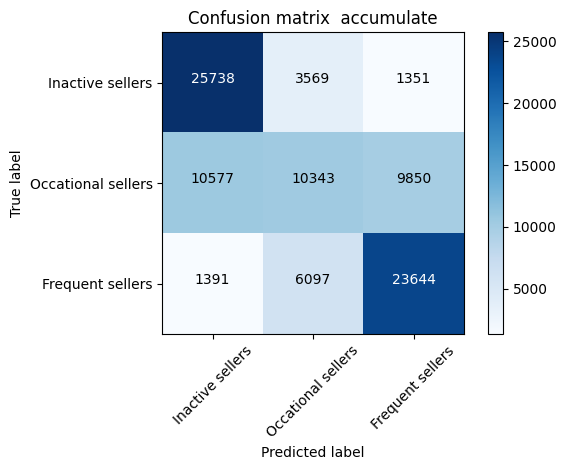

In [61]:
balanced(X_ros, Y_ros, model)

We could clearly observe more balanced f1-score that the f1-score of case 'HasBought'=1 increased significantly although 0's dropped slightly.


Re-split the filtered dataset


In [62]:
# according to the correlation heatmap, pairplot and feature selection, keep top 7
d_columns = [
    "productsPassRate",
    "hasAndroidApp_encoded",
    "daysSinceLastLogin",
    "hasProfilePicture_encoded",
    "productsListed",
    "socialProductsLiked",
    "socialNbFollows",
    "socialNbFollowers",
]
# socialNBFollows & socialProductsLiked has no relationship with a user's willingness to buy a product
Xf_ros = X_ros.drop(d_columns, axis=1)
Yf_ros = Y_ros

Balanced Model Re-evaluation with Filtered Dataset


Balanced Filtered Model Evaluation: 
Accuracy on train set: 0.543
Accuracy on test set: 0.543
Model Evaluation:
classification report of train set: 
              precision    recall  f1-score   support

           0       0.52      0.89      0.65     62836
           1       0.43      0.18      0.25     62724
           2       0.65      0.56      0.60     62362

    accuracy                           0.54    187922
   macro avg       0.53      0.54      0.50    187922
weighted avg       0.53      0.54      0.50    187922

classification report of test set: 
              precision    recall  f1-score   support

           0       0.51      0.89      0.65     30658
           1       0.43      0.18      0.26     30770
           2       0.66      0.56      0.60     31132

    accuracy                           0.54     92560
   macro avg       0.53      0.54      0.50     92560
weighted avg       0.53      0.54      0.50     92560

Confusion matrix of test set: 
Balanced Filtered Mode

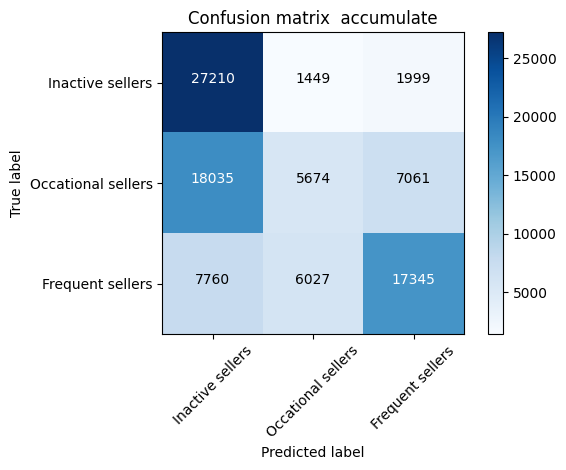

In [63]:
balancedFilt(Xf_ros, Yf_ros, model)

Prédiction mise à jour des nouveaux utilisateurs.


In [64]:
c = Xf_ros
c.dataframeName = "Formean"
c.describe()

,productsSold,productsWished,civilityGenderId,language_encoded,countryCode_encoded,hasAnyApp_encoded,hasIosApp_encoded
count,280482.000000,280482.000000,280482.000000,280482.000000,280482.000000,280482.000000,280482.000000
mean,0.723537,22.538327,1.758655,1.663857,90.089214,0.400525,0.334841
std,5.329800,108.677469,0.449605,1.165205,53.304537,0.490006,0.471936
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,58.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000,1.000000,64.000000,0.000000,0.000000
75%,0.000000,4.000000,2.000000,3.000000,140.000000,1.000000,1.000000
max,174.000000,2635.000000,3.000000,4.000000,198.000000,1.000000,1.000000


In [65]:
# try to predict when a user using mean
newdata = [[1, 22, 2, 2, 90, 0, 0]]
Y_pred1 = model.predict(newdata)
print("prediction with mean features: ", Y_pred1)
# socialNbFollowers affect the prediction the most

# try to predict when a user using max
newdata1 = [[174, 2635, 3, 4, 198, 1, 1]]
Y_pred2 = model.predict(newdata1)
print("prediction with max features: ", Y_pred2)

# save the model
with open("models/linear_regression.pkl", "wb") as f:
    pickle.dump(model, f)

prediction with mean features:  ['1']
prediction with max features:  ['2']


Les deux ont utilisé countryCode_encoded, language_encoded, hasIosApp_encoded, productsWished et civilityGenderId.
Le modèle déséquilibré a utilisé daysSinceLast Login et hasAndroidApp_encoded.
Le modèle équilibré a utilisé productsSold.

La prédiction de l'ensemble de données équilibrées a un score F1 significativement plus élevé pour HasBought=1.


# Extreme Gradient Boosting


Model Built


In [66]:
import xgboost as xgb

model = xgb.XGBClassifier()
Y = Y.astype(int)

Model Evaluation


Original Model Evaluation: 
Accuracy on train set: 0.966
Accuracy on test set: 0.946
Model Evaluation:
classification report of train set: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     62691
           1       0.90      0.30      0.45      2754
           2       0.98      0.68      0.80       826

    accuracy                           0.97     66271
   macro avg       0.95      0.66      0.74     66271
weighted avg       0.96      0.97      0.96     66271

classification report of test set: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     30803
           1       0.36      0.10      0.15      1388
           2       0.53      0.34      0.42       451

    accuracy                           0.95     32642
   macro avg       0.62      0.48      0.51     32642
weighted avg       0.92      0.95      0.93     32642

Confusion matrix of test set: 
Original Model's features selec

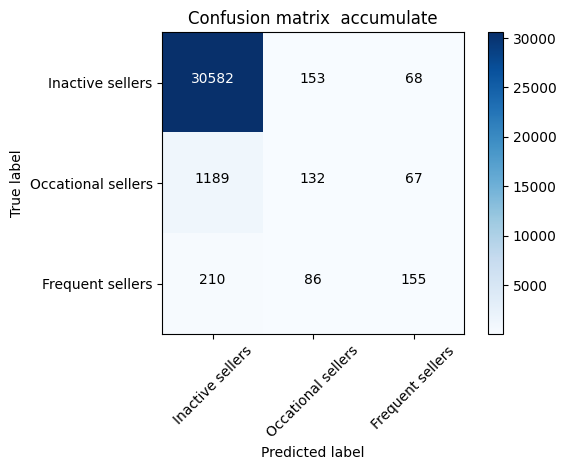

In [67]:
org(X, Y, model)

Le score F1 du jeu d'entraînement et du jeu de test a augmenté de manière significative par rapport à celui de la régression logistique.


Re-split the filtered dataset


In [68]:
# according to the correlation heatmap, pairplot and feature selection, keep top 7

d_columns = [
    "productsSold",
    "socialNbFollowers",
    "language_encoded",
    "hasAndroidApp_encoded",
    "productsListed",
    "hasAnyApp_encoded",
    "daysSinceLastLogin",
    "hasProfilePicture_encoded",
]

# socialNBFollows & socialProductsLiked has no relationship with a user's willingness to buy a product
Xf = X.drop(d_columns, axis=1)
Yf = db3["HasBought"]
Xy = db3[["productsBought"]]
Xf_pp = pd.concat([Xf, Xy], join="outer", axis=1)

Visualiser la relation entre une variable individuelle et la variable dépendante.


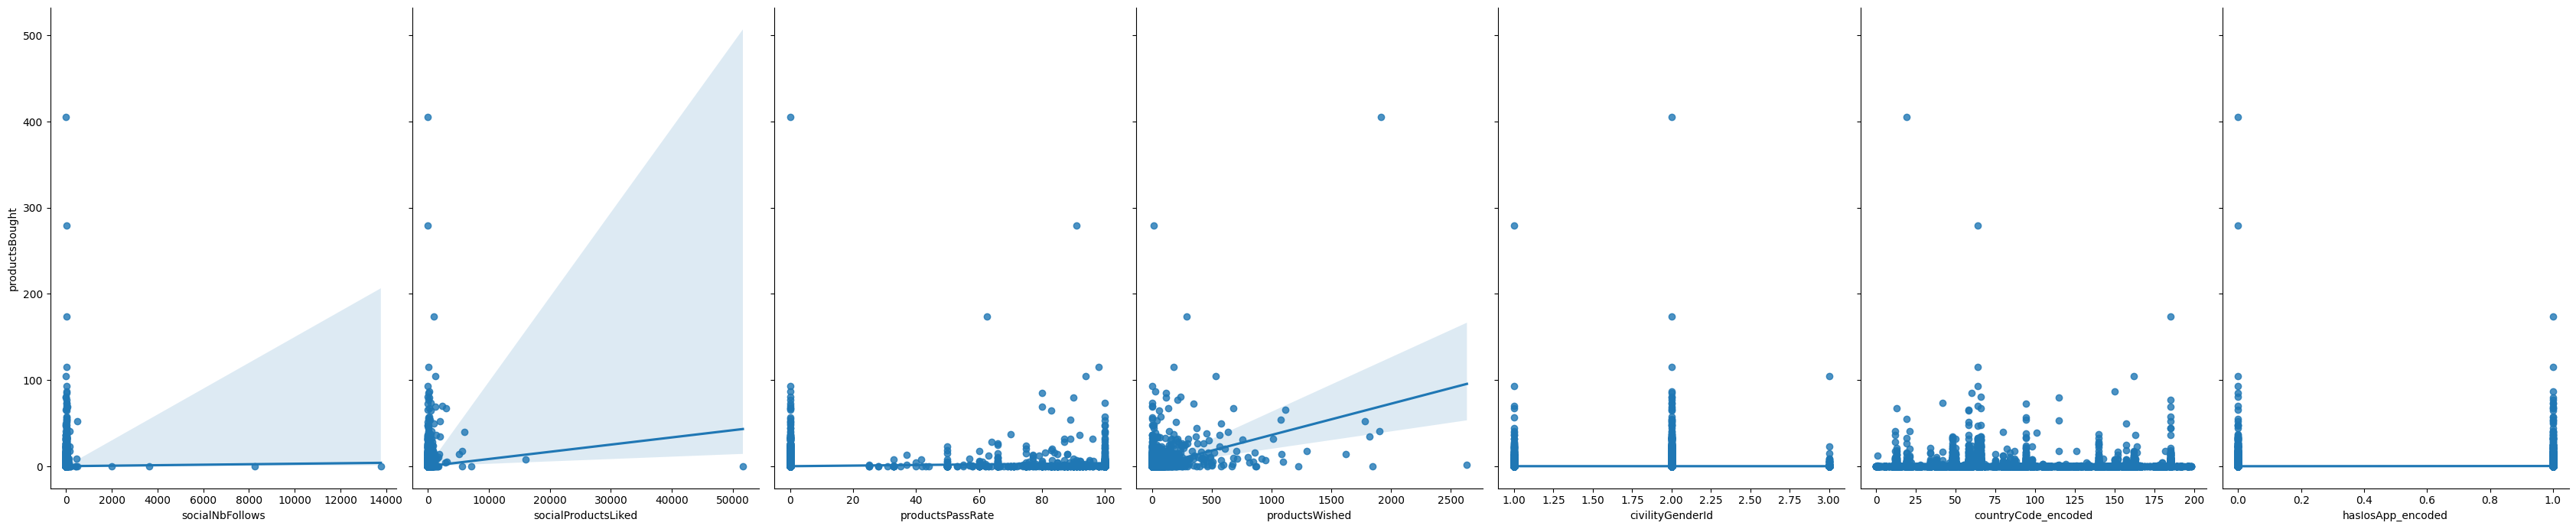

In [69]:
import seaborn as sns

sns.pairplot(
    Xf_pp, x_vars=Xf.columns, y_vars="productsBought", height=7, aspect=0.7, kind="reg"
)

Model Re-evaluation with the Filtered Dataset


Filtered Model Evaluation: 
Accuracy on train set: 0.960
Accuracy on test set: 0.944
Model Evaluation:
classification report of train set: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     62691
           1       0.94      0.17      0.28      2754
           2       0.98      0.56      0.71       826

    accuracy                           0.96     66271
   macro avg       0.96      0.57      0.66     66271
weighted avg       0.96      0.96      0.95     66271

classification report of test set: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     30803
           1       0.27      0.04      0.07      1388
           2       0.48      0.26      0.34       451

    accuracy                           0.94     32642
   macro avg       0.57      0.43      0.46     32642
weighted avg       0.92      0.94      0.93     32642

Confusion matrix of test set: 
Filtered Model's Feature Import

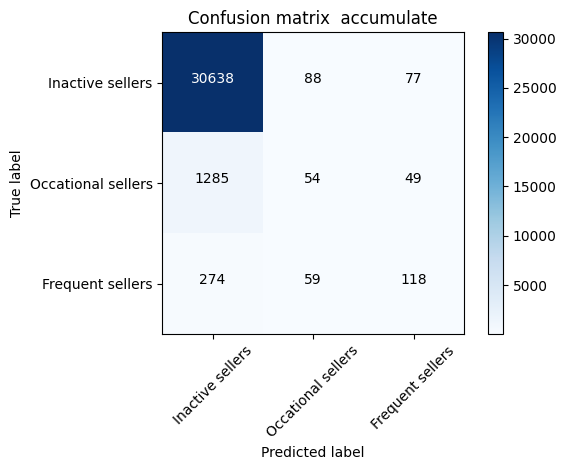

In [70]:
Yf = Yf.astype(int)
filt(Xf, Yf, model)

Prédiction des nouveaux utilisateurs.


In [71]:
c = Xf
c.dataframeName = "Formean"
c.describe()

,socialNbFollows,socialProductsLiked,productsPassRate,productsWished,civilityGenderId,countryCode_encoded,hasIosApp_encoded
count,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000
mean,8.425677,4.420743,0.812303,1.562595,1.773993,93.711635,0.217636
std,52.839572,181.030569,8.500205,25.192793,0.428679,55.173154,0.412640
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,8.000000,0.000000,0.000000,0.000000,2.000000,64.000000,0.000000
50%,8.000000,0.000000,0.000000,0.000000,2.000000,66.000000,0.000000
75%,8.000000,0.000000,0.000000,0.000000,2.000000,152.000000,0.000000
max,13764.000000,51671.000000,100.000000,2635.000000,3.000000,198.000000,1.000000


In [72]:
# try to predict when a user using mean and max
nUser = {
    "socialNbFollows": [8, 13764],
    "socialProductsLiked": [4, 51671],
    "productsPassRate": [1, 100],
    "productsWished": [2, 2635],
    "civilityGenderId": [2, 3],
    "countryCode_encoded": [94, 198],
    "hasIosApp_encoded": [0, 1],
}

df2 = pd.DataFrame(
    nUser,
    columns=[
        "socialNbFollows",
        "socialProductsLiked",
        "productsPassRate",
        "productsWished",
        "civilityGenderId",
        "countryCode_encoded",
        "hasIosApp_encoded",
    ],
)

Y_pred2 = model.predict(df2)
Y_pred2

array([0, 0])

In [73]:
print(db3["HasBought"].value_counts())
# very imbalanced sample

HasBought
0    93494
1     4142
2     1277
Name: count, dtype: int64


## Bootstrap to resample the imbalanced data


Balanced Model Evaluation


Balanced Model Evaluation: 
Accuracy on train set: 0.868
Accuracy on test set: 0.861
Model Evaluation:
classification report of train set: 
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     62836
           1       0.81      0.81      0.81     62724
           2       0.96      0.94      0.95     62362

    accuracy                           0.87    187922
   macro avg       0.87      0.87      0.87    187922
weighted avg       0.87      0.87      0.87    187922

classification report of test set: 
              precision    recall  f1-score   support

           0       0.83      0.84      0.83     30658
           1       0.80      0.81      0.80     30770
           2       0.95      0.94      0.95     31132

    accuracy                           0.86     92560
   macro avg       0.86      0.86      0.86     92560
weighted avg       0.86      0.86      0.86     92560

Confusion matrix of test set: 
Balanced Model's feature Select

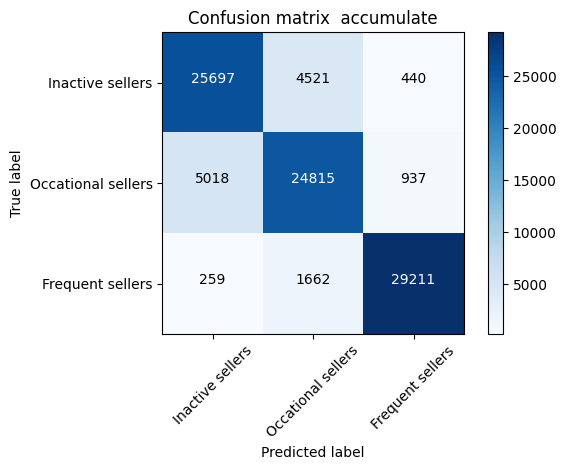

In [74]:
Y_ros = Y_ros.astype(int)
balanced(X_ros, Y_ros, model)

In [75]:
# according to the correlation heatmap, pairplot and feature selection, keep top 7
d_columns = [
    "productsPassRate",
    "socialNbFollowers",
    "countryCode_encoded",
    "daysSinceLastLogin",
    "productsListed",
    "hasAnyApp_encoded",
    "productsWished",
    "language_encoded",
]
Xf_ros = X_ros.drop(d_columns, axis=1)
Yf_ros = Y_ros

Balanced Model Re-evaluation with the Filtered Dataset


Balanced Filtered Model Evaluation: 
Accuracy on train set: 0.676
Accuracy on test set: 0.671
Model Evaluation:
classification report of train set: 
              precision    recall  f1-score   support

           0       0.62      0.85      0.72     62836
           1       0.61      0.46      0.53     62724
           2       0.83      0.71      0.76     62362

    accuracy                           0.68    187922
   macro avg       0.68      0.68      0.67    187922
weighted avg       0.68      0.68      0.67    187922

classification report of test set: 
              precision    recall  f1-score   support

           0       0.62      0.85      0.71     30658
           1       0.60      0.46      0.52     30770
           2       0.82      0.70      0.76     31132

    accuracy                           0.67     92560
   macro avg       0.68      0.67      0.66     92560
weighted avg       0.68      0.67      0.67     92560

Confusion matrix of test set: 
Balanced Filtered Mode

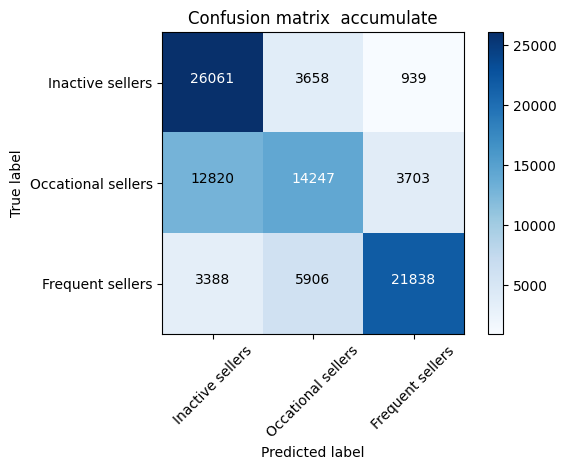

In [76]:
balancedFilt(Xf_ros, Yf_ros, model)

New User's Prediction


In [77]:
c = Xf_ros
c.dataframeName = "Formean"
c.describe()

,socialNbFollows,socialProductsLiked,productsSold,civilityGenderId,hasAndroidApp_encoded,hasIosApp_encoded,hasProfilePicture_encoded
count,280482.000000,280482.000000,280482.000000,280482.000000,280482.000000,280482.000000,280482.000000
mean,9.515609,46.530005,0.723537,1.758655,0.075741,0.334841,0.902525
std,33.594663,345.690141,5.329800,0.449605,0.264584,0.471936,0.296604
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,8.000000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000
75%,8.000000,12.000000,0.000000,2.000000,0.000000,1.000000,1.000000
max,13764.000000,51671.000000,174.000000,3.000000,1.000000,1.000000,1.000000


In [78]:
# try to predict when a user using mean and max
nUser = {
    "socialNbFollows": [10, 13764],
    "socialProductsLiked": [47, 51671],
    "productsSold": [1, 174],
    "civilityGenderId": [2, 3],
    "hasAndroidApp_encoded": [0, 1],
    "hasIosApp_encoded": [0, 1],
    "hasProfilePicture_encoded": [1, 1],
}

df2 = pd.DataFrame(
    nUser,
    columns=[
        "socialNbFollows",
        "socialProductsLiked",
        "productsSold",
        "civilityGenderId",
        "hasAndroidApp_encoded",
        "hasIosApp_encoded",
        "hasProfilePicture_encoded",
    ],
)

Y_pred2 = model.predict(df2)
Y_pred2

array([2, 0])

Pour l'ensemble de données filtré (à la fois déséquilibré et équilibré) :
Les deux ont utilisé productsWished, civilityGenderId, countryCode_encoded et hasIosApp_encoded.
Le modèle déséquilibré a utilisé socialProductsLiked, socialNbFollows et productsPassRate.
Le modèle équilibré a utilisé productsSold, language_encoded et hasAnyApp_encoded.

La prédiction de l'ensemble de données équilibrées a un score F1 significativement plus élevé pour HasBought=1.


# HasSold As Predictor


Define X and Y


In [79]:
X = db3[
    [
        "socialNbFollowers",
        "socialNbFollows",
        "socialProductsLiked",
        "productsListed",
        "productsBought",
        "productsPassRate",
        "productsWished",
        "civilityGenderId",
        "daysSinceLastLogin",
        "language_encoded",
        "countryCode_encoded",
        "hasAnyApp_encoded",
        "hasAndroidApp_encoded",
        "hasIosApp_encoded",
        "hasProfilePicture_encoded",
    ]
]
Y = db3["HasSold"] = db3["productsSold"].apply(
    lambda x: "2" if x >= 6 else ("1" if x < 6 and x > 0 else "0")
)

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42
)
models(X_train, Y_train, X_test, Y_test)

Select 1 : Naive Bayes, 2: Support Vector Machines, 3: Logistic Regression, 4: Decision Tree, 5: RandomForestClassifier,6: Extreme gradient boosting
testing set accuracy score:  0.9704368604864898
testing set accuracy mean:  0.9700924984648397
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     31952
           1       0.30      0.56      0.39       551
           2       0.70      0.35      0.47       139

    accuracy                           0.97     32642
   macro avg       0.66      0.63      0.62     32642
weighted avg       0.98      0.97      0.97     32642

confusion matrix: 
[[31321   624     7]
 [  230   307    14]
 [    0    90    49]]


# Improve model with the best performance

Puisque tous ont presque la même précision sur l'ensemble de test, il n'y a pas de modèle avec une meilleure performance à améliorer.


Model Built


In [81]:
import xgboost as xgb

model = xgb.XGBClassifier()

Model Evaluation


Original Model Evaluation: 
Accuracy on train set: 0.995
Accuracy on test set: 0.987
Model Evaluation:
classification report of train set: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64925
           1       0.98      0.68      0.80      1027
           2       1.00      1.00      1.00       319

    accuracy                           0.99     66271
   macro avg       0.99      0.89      0.93     66271
weighted avg       0.99      0.99      0.99     66271

classification report of test set: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     31952
           1       0.73      0.35      0.47       551
           2       0.78      0.88      0.83       139

    accuracy                           0.99     32642
   macro avg       0.83      0.74      0.76     32642
weighted avg       0.98      0.99      0.98     32642

Confusion matrix of test set: 
Original Model's features selec

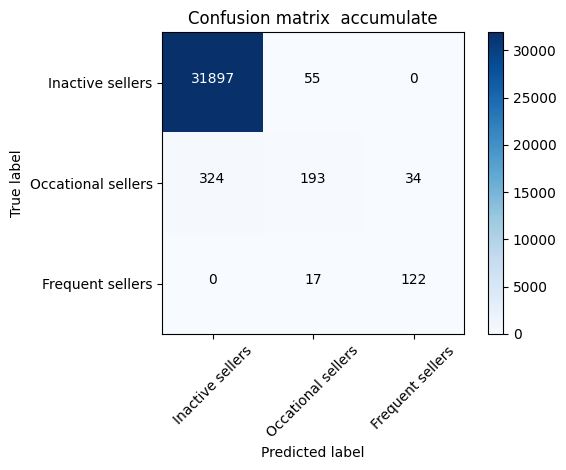

In [82]:
Y = Y.astype(int)
org(X, Y, model)

Re-split the filtered dataset


In [83]:
# according to the correlation heatmap, pairplot and feature selection, keep top 7
d_columns = [
    "productsBought",
    "productsListed",
    "productsPassRate",
    "civilityGenderId",
    "language_encoded",
    "hasAndroidApp_encoded",
    "hasProfilePicture_encoded",
    "productsWished",
]

# socialNBFollows & socialProductsLiked has no relationship with a user's willingness to buy a product
Xf = X.drop(d_columns, axis=1)
Yf = db3["HasSold"]
Xy = db3[["productsSold"]]
Xf_pp = pd.concat([Xf, Xy], join="outer", axis=1)

Visualiser la relation entre une variable individuelle et la variable dépendante.


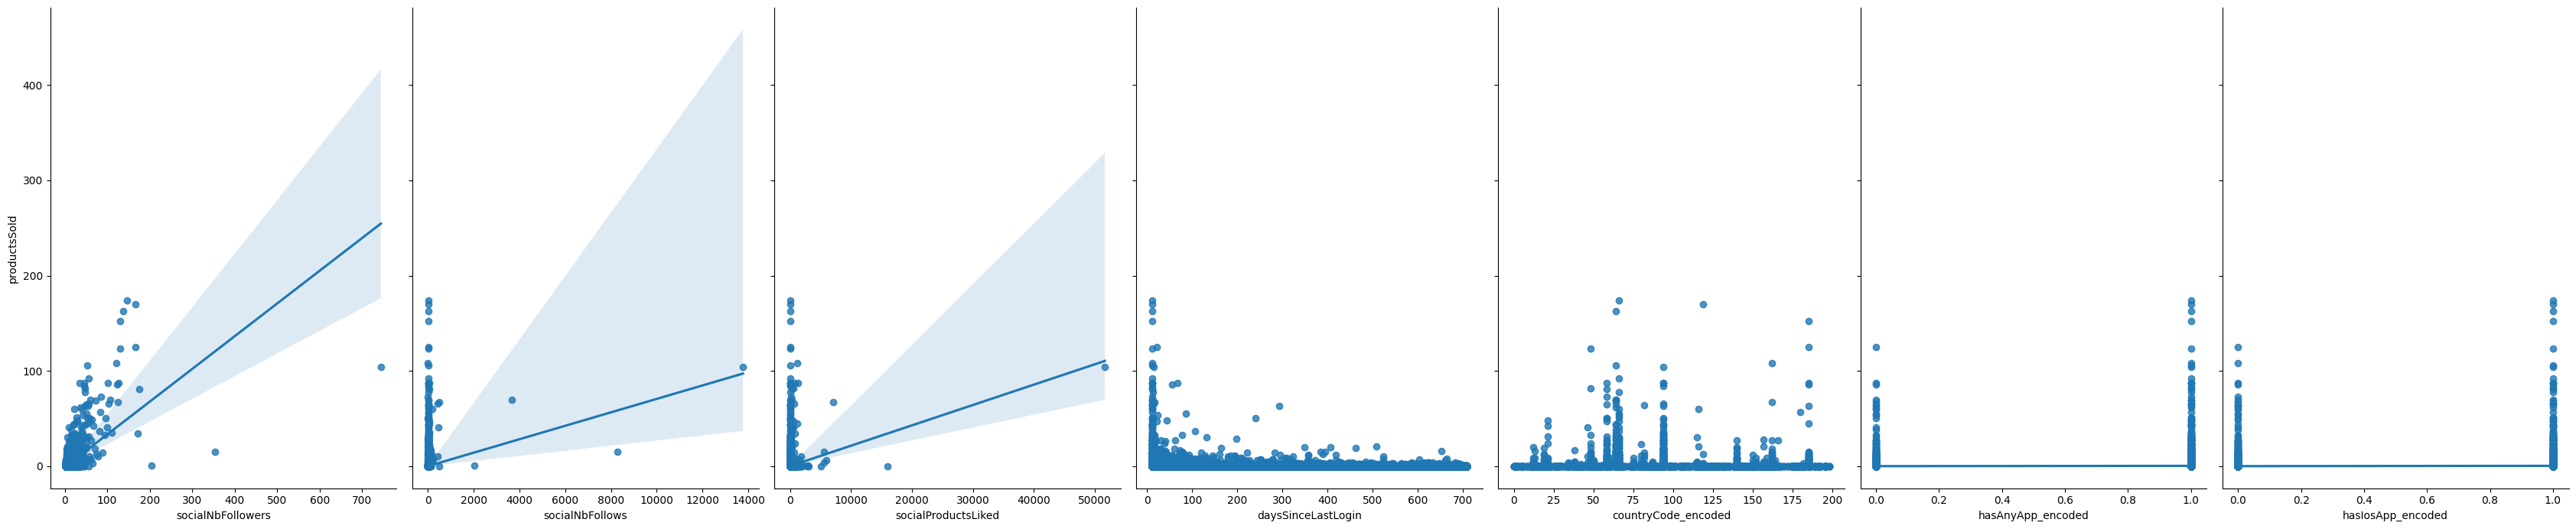

In [84]:
import seaborn as sns

sns.pairplot(
    Xf_pp, x_vars=Xf.columns, y_vars="productsSold", height=7, aspect=0.7, kind="reg"
)

Model Re-evaluation with the Filtered Dataset


Filtered Model Evaluation: 
Accuracy on train set: 0.991
Accuracy on test set: 0.980
Model Evaluation:
classification report of train set: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     64925
           1       0.93      0.45      0.61      1027
           2       0.95      0.92      0.93       319

    accuracy                           0.99     66271
   macro avg       0.96      0.79      0.85     66271
weighted avg       0.99      0.99      0.99     66271

classification report of test set: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     31952
           1       0.38      0.12      0.18       551
           2       0.55      0.46      0.50       139

    accuracy                           0.98     32642
   macro avg       0.64      0.53      0.56     32642
weighted avg       0.97      0.98      0.98     32642

Confusion matrix of test set: 
Filtered Model's Feature Import

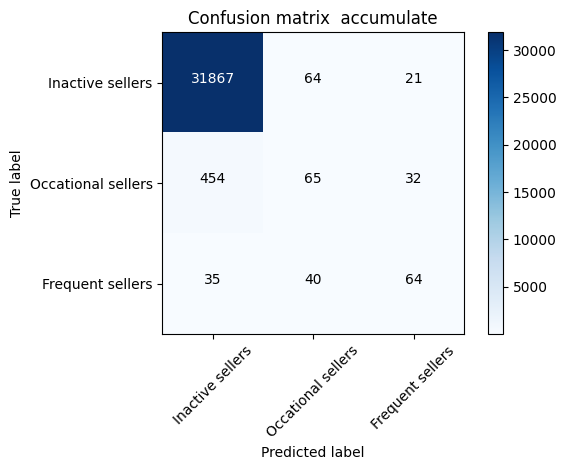

In [85]:
Yf = Yf.astype(int)
filt(Xf, Yf, model)

Le score F1 pour HasSold=1 a considérablement diminué sur l'ensemble de données filtré.


New users' prediction


In [86]:
c = Xf
c.dataframeName = "Formean"
c.describe()

,socialNbFollowers,socialNbFollows,socialProductsLiked,daysSinceLastLogin,countryCode_encoded,hasAnyApp_encoded,hasIosApp_encoded
count,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000
mean,3.432269,8.425677,4.420743,581.291236,93.711635,0.264616,0.217636
std,3.882383,52.839572,181.030569,208.855888,55.173154,0.441131,0.412640
min,3.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000
25%,3.000000,8.000000,0.000000,572.000000,64.000000,0.000000,0.000000
50%,3.000000,8.000000,0.000000,694.000000,66.000000,0.000000,0.000000
75%,3.000000,8.000000,0.000000,702.000000,152.000000,1.000000,0.000000
max,744.000000,13764.000000,51671.000000,709.000000,198.000000,1.000000,1.000000


In [87]:
# try to predict when a user using mean and max
nUser = {
    "socialNbFollowers": [3, 744],
    "socialNbFollows": [8, 13764],
    "socialProductsLiked": [4, 51671],
    "daysSinceLastLogin": [581, 709],
    "countryCode_encoded": [94, 198],
    "hasAnyApp_encoded": [0, 1],
    "hasIosApp_encoded": [0, 1],
}

df2 = pd.DataFrame(
    nUser,
    columns=[
        "socialNbFollowers",
        "socialNbFollows",
        "socialProductsLiked",
        "daysSinceLastLogin",
        "countryCode_encoded",
        "hasAnyApp_encoded",
        "hasIosApp_encoded",
    ],
)

Y_pred2 = model.predict(df2)
Y_pred2

array([0, 0])

## Bootstrap to resample the imbalanced data


In [88]:
from collections import Counter
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
X_ros, Y_ros = ros.fit_resample(X, Y)
print("Original dataset shape", Counter(Y))
print("Resample dataset shape", Counter(Y_ros))

X_ros = pd.DataFrame(
    X_ros,
    columns=[
        "socialNbFollowers",
        "socialNbFollows",
        "socialProductsLiked",
        "productsListed",
        "productsBought",
        "productsPassRate",
        "productsWished",
        "civilityGenderId",
        "daysSinceLastLogin",
        "language_encoded",
        "countryCode_encoded",
        "hasAnyApp_encoded",
        "hasAndroidApp_encoded",
        "hasIosApp_encoded",
        "hasProfilePicture_encoded",
    ],
)
Y_ros.to_frame()

Original dataset shape Counter({0: 96877, 1: 1578, 2: 458})
Resample dataset shape Counter({0: 96877, 1: 96877, 2: 96877})


,productsSold
0,0
1,0
2,0
3,0
4,0
...,...
290626,2
290627,2
290628,2
290629,2


Balanced Model Evaluation


Balanced Model Evaluation: 
Accuracy on train set: 0.980
Accuracy on test set: 0.976
Model Evaluation:
classification report of train set: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     65006
           1       0.97      0.97      0.97     64896
           2       1.00      1.00      1.00     64820

    accuracy                           0.98    194722
   macro avg       0.98      0.98      0.98    194722
weighted avg       0.98      0.98      0.98    194722

classification report of test set: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     31871
           1       0.96      0.97      0.96     31981
           2       1.00      1.00      1.00     32057

    accuracy                           0.98     95909
   macro avg       0.98      0.98      0.98     95909
weighted avg       0.98      0.98      0.98     95909

Confusion matrix of test set: 
Balanced Model's feature Select

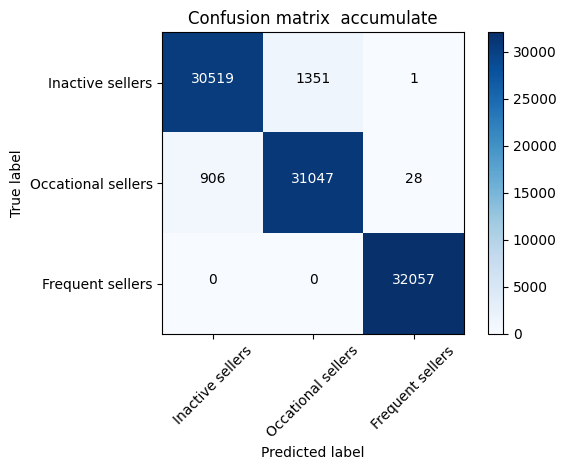

In [89]:
balanced(X_ros, Y_ros, model)

In [90]:
# according to the correlation heatmap, pairplot and feature selection, keep top 7

d_columns = [
    "productsWished",
    "productsListed",
    "productsPassRate",
    "daysSinceLastLogin",
    "hasIosApp_encoded",
    "hasProfilePicture_encoded",
    "hasAndroidApp_encoded",
    "productsBought",
]

Xf_ros = X_ros.drop(d_columns, axis=1)
Yf_ros = Y_ros

Balanced Model Re-evaluation with the Filtered Dataset


Balanced Filtered Model Evaluation: 
Accuracy on train set: 0.907
Accuracy on test set: 0.902
Model Evaluation:
classification report of train set: 
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     65006
           1       0.88      0.84      0.86     64896
           2       0.96      0.96      0.96     64820

    accuracy                           0.91    194722
   macro avg       0.91      0.91      0.91    194722
weighted avg       0.91      0.91      0.91    194722

classification report of test set: 
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     31871
           1       0.87      0.84      0.86     31981
           2       0.95      0.96      0.96     32057

    accuracy                           0.90     95909
   macro avg       0.90      0.90      0.90     95909
weighted avg       0.90      0.90      0.90     95909

Confusion matrix of test set: 
Balanced Filtered Mode

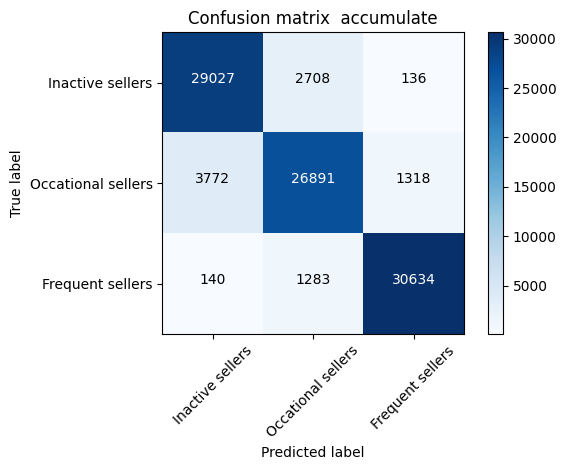

In [91]:
balancedFilt(Xf_ros, Yf_ros, model)

En général, la précision globale et le score F1 pour HasSold=1 ont diminué sur l'ensemble de données filtré pour les cas équilibrés et déséquilibrés. En particulier, le score F1 pour HasSold=1 a considérablement diminué dans les cas déséquilibrés.


New User's Prediction


In [92]:
c = Xf_ros
c.dataframeName = "Formean"
c.describe()
c.describe().to_csv("described.csv")

In [93]:
# try to predict when a user using mean and max
nUser = {
    "socialNbFollowers": [13, 744],
    "socialNbFollows": [31, 13764],
    "socialProductsLiked": [78, 51671],
    "civilityGenderId": [2, 3],
    "language_encoded": [2, 4],
    "countryCode_encoded": [86, 198],
    "hasAnyApp_encoded": [1, 1],
}

df2 = pd.DataFrame(
    nUser,
    columns=[
        "socialNbFollowers",
        "socialNbFollows",
        "socialProductsLiked",
        "civilityGenderId",
        "language_encoded",
        "countryCode_encoded",
        "hasAnyApp_encoded",
    ],
)
with open("models/XGB.pkl", "wb") as f:
    pickle.dump(model, f)
Y_pred2 = model.predict(df2)
Y_pred2

array([2, 2])

Pour l'ensemble de données filtré (à la fois déséquilibré et équilibré) :
Les deux ont utilisé les variables socialNbFollwers, countryCode_encoded, socialNbFollows, socialProductsLiked et hasAnyApp_encoded.
L'ensemble de données déséquilibrées a utilisé les variables daysSinceLastLogin et hasIosApp_encoded.
L'ensemble de données équilibrées a utilisé language_encoded et civilityGenderId.

Ils ont choisi presque les mêmes variables pour la construction du modèle. Cependant, la prédiction de l'ensemble de données équilibrées n'a qu'un score F1 légèrement inférieur pour HasBought=1.
